<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:13:39] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


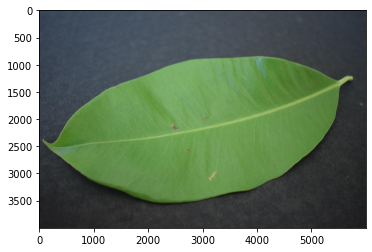

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

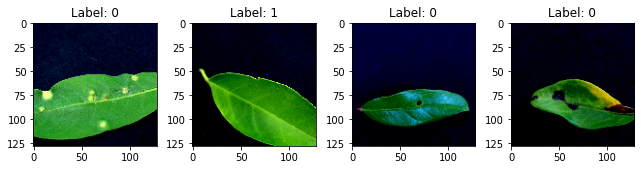

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:13:47] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:13:49] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.254420997617102 samples/sec                   batch loss = 0.5385490655899048 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2602750304322792 samples/sec                   batch loss = 0.4566996693611145 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2633227936054416 samples/sec                   batch loss = 0.7263852953910828 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2628041780012365 samples/sec                   batch loss = 0.6219991445541382 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2689162481434861 samples/sec                   batch loss = 0.7741819620132446 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2495305848780967 samples/sec                   batch loss = 0.8098654747009277 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.2638714452048685 samples/sec                   batch loss = 0.7969726920127869 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2676436849610901 samples/sec                   batch loss = 0.5509490370750427 | accuracy = 0.55


Epoch[1] Batch[45] Speed: 1.264665429933221 samples/sec                   batch loss = 0.47987350821495056 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.2662777084782002 samples/sec                   batch loss = 0.5926371812820435 | accuracy = 0.57


Epoch[1] Batch[55] Speed: 1.2675995319530022 samples/sec                   batch loss = 1.4252569675445557 | accuracy = 0.5545454545454546


Epoch[1] Batch[60] Speed: 1.2695364363692496 samples/sec                   batch loss = 1.0008180141448975 | accuracy = 0.5416666666666666


Epoch[1] Batch[65] Speed: 1.2662956765733637 samples/sec                   batch loss = 0.58353191614151 | accuracy = 0.5576923076923077


Epoch[1] Batch[70] Speed: 1.2632466006025136 samples/sec                   batch loss = 0.6849542260169983 | accuracy = 0.5571428571428572


Epoch[1] Batch[75] Speed: 1.2685815849572373 samples/sec                   batch loss = 0.5953128337860107 | accuracy = 0.5666666666666667


Epoch[1] Batch[80] Speed: 1.2691083178362454 samples/sec                   batch loss = 0.6205925345420837 | accuracy = 0.56875


Epoch[1] Batch[85] Speed: 1.2682528505462216 samples/sec                   batch loss = 0.6767551302909851 | accuracy = 0.5735294117647058


Epoch[1] Batch[90] Speed: 1.2683651265997622 samples/sec                   batch loss = 0.687807023525238 | accuracy = 0.5861111111111111


Epoch[1] Batch[95] Speed: 1.275613424386796 samples/sec                   batch loss = 0.7326517105102539 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2738925622093782 samples/sec                   batch loss = 0.46849825978279114 | accuracy = 0.5975


Epoch[1] Batch[105] Speed: 1.2709800291207267 samples/sec                   batch loss = 1.0610935688018799 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.2745071689250635 samples/sec                   batch loss = 0.3608754277229309 | accuracy = 0.615909090909091


Epoch[1] Batch[115] Speed: 1.2685518499243167 samples/sec                   batch loss = 0.42059943079948425 | accuracy = 0.6152173913043478


Epoch[1] Batch[120] Speed: 1.2706087672769555 samples/sec                   batch loss = 1.0828715562820435 | accuracy = 0.6104166666666667


Epoch[1] Batch[125] Speed: 1.2655381141801354 samples/sec                   batch loss = 0.2897805869579315 | accuracy = 0.62


Epoch[1] Batch[130] Speed: 1.2645862153359764 samples/sec                   batch loss = 0.8623492121696472 | accuracy = 0.6192307692307693


Epoch[1] Batch[135] Speed: 1.2633262182258949 samples/sec                   batch loss = 0.3730277419090271 | accuracy = 0.6277777777777778


Epoch[1] Batch[140] Speed: 1.2607283770621176 samples/sec                   batch loss = 0.4586363136768341 | accuracy = 0.6321428571428571


Epoch[1] Batch[145] Speed: 1.2564816151778209 samples/sec                   batch loss = 0.5315710306167603 | accuracy = 0.6310344827586207


Epoch[1] Batch[150] Speed: 1.2633786362614294 samples/sec                   batch loss = 1.0597865581512451 | accuracy = 0.6316666666666667


Epoch[1] Batch[155] Speed: 1.264879101446039 samples/sec                   batch loss = 0.750526487827301 | accuracy = 0.6338709677419355


Epoch[1] Batch[160] Speed: 1.2678665082301062 samples/sec                   batch loss = 0.8636081218719482 | accuracy = 0.634375


Epoch[1] Batch[165] Speed: 1.2677810482586351 samples/sec                   batch loss = 0.5744911432266235 | accuracy = 0.6318181818181818


Epoch[1] Batch[170] Speed: 1.2674228549274669 samples/sec                   batch loss = 0.5767982006072998 | accuracy = 0.6323529411764706


Epoch[1] Batch[175] Speed: 1.2726161813373926 samples/sec                   batch loss = 0.9173800945281982 | accuracy = 0.6271428571428571


Epoch[1] Batch[180] Speed: 1.2630855887004495 samples/sec                   batch loss = 0.5725311636924744 | accuracy = 0.6263888888888889


Epoch[1] Batch[185] Speed: 1.2697183156684795 samples/sec                   batch loss = 0.2664523124694824 | accuracy = 0.6270270270270271


Epoch[1] Batch[190] Speed: 1.2639006755758577 samples/sec                   batch loss = 0.5882667303085327 | accuracy = 0.631578947368421


Epoch[1] Batch[195] Speed: 1.2614820874030337 samples/sec                   batch loss = 0.2820742726325989 | accuracy = 0.6307692307692307


Epoch[1] Batch[200] Speed: 1.2663374448074343 samples/sec                   batch loss = 0.365543395280838 | accuracy = 0.6325


Epoch[1] Batch[205] Speed: 1.2677633253796572 samples/sec                   batch loss = 0.7158682346343994 | accuracy = 0.6317073170731707


Epoch[1] Batch[210] Speed: 1.2654287241758415 samples/sec                   batch loss = 0.4154105484485626 | accuracy = 0.6345238095238095


Epoch[1] Batch[215] Speed: 1.2699420612006245 samples/sec                   batch loss = 0.4760199189186096 | accuracy = 0.6372093023255814


Epoch[1] Batch[220] Speed: 1.2728233744930146 samples/sec                   batch loss = 0.6493593454360962 | accuracy = 0.6375


Epoch[1] Batch[225] Speed: 1.2694421064068888 samples/sec                   batch loss = 0.5972639322280884 | accuracy = 0.6377777777777778


Epoch[1] Batch[230] Speed: 1.2687521566883069 samples/sec                   batch loss = 0.6813670992851257 | accuracy = 0.6423913043478261


Epoch[1] Batch[235] Speed: 1.2756923775529392 samples/sec                   batch loss = 0.410127192735672 | accuracy = 0.6425531914893617


Epoch[1] Batch[240] Speed: 1.2750746893674716 samples/sec                   batch loss = 0.4047548770904541 | accuracy = 0.6479166666666667


Epoch[1] Batch[245] Speed: 1.281194766512381 samples/sec                   batch loss = 0.7672207951545715 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.2706346532757822 samples/sec                   batch loss = 0.4311695992946625 | accuracy = 0.654


Epoch[1] Batch[255] Speed: 1.2705161059716592 samples/sec                   batch loss = 0.5092602968215942 | accuracy = 0.6549019607843137


Epoch[1] Batch[260] Speed: 1.2779446143786837 samples/sec                   batch loss = 0.2226983904838562 | accuracy = 0.6576923076923077


Epoch[1] Batch[265] Speed: 1.2705456445048908 samples/sec                   batch loss = 0.6846104264259338 | accuracy = 0.6566037735849056


Epoch[1] Batch[270] Speed: 1.273171197393861 samples/sec                   batch loss = 0.6309153437614441 | accuracy = 0.6555555555555556


Epoch[1] Batch[275] Speed: 1.2647123342277242 samples/sec                   batch loss = 0.4044761061668396 | accuracy = 0.6563636363636364


Epoch[1] Batch[280] Speed: 1.2717171310606752 samples/sec                   batch loss = 0.40763145685195923 | accuracy = 0.6589285714285714


Epoch[1] Batch[285] Speed: 1.2605688588425998 samples/sec                   batch loss = 0.7314033508300781 | accuracy = 0.6596491228070176


Epoch[1] Batch[290] Speed: 1.2657200909296937 samples/sec                   batch loss = 0.3436586558818817 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.2645569532476468 samples/sec                   batch loss = 0.2962113618850708 | accuracy = 0.6627118644067796


Epoch[1] Batch[300] Speed: 1.2646795389892735 samples/sec                   batch loss = 0.3114778995513916 | accuracy = 0.6633333333333333


Epoch[1] Batch[305] Speed: 1.268712435664358 samples/sec                   batch loss = 0.6807690262794495 | accuracy = 0.6631147540983606


Epoch[1] Batch[310] Speed: 1.2691640970906735 samples/sec                   batch loss = 0.4360297620296478 | accuracy = 0.6637096774193548


Epoch[1] Batch[315] Speed: 1.2607699683154558 samples/sec                   batch loss = 0.7202661037445068 | accuracy = 0.665079365079365


Epoch[1] Batch[320] Speed: 1.2620745207909752 samples/sec                   batch loss = 0.13865886628627777 | accuracy = 0.66484375


Epoch[1] Batch[325] Speed: 1.2585323977340257 samples/sec                   batch loss = 0.40674805641174316 | accuracy = 0.6653846153846154


Epoch[1] Batch[330] Speed: 1.2619934470760146 samples/sec                   batch loss = 0.49808597564697266 | accuracy = 0.6659090909090909


Epoch[1] Batch[335] Speed: 1.2644956692881042 samples/sec                   batch loss = 0.3018309772014618 | accuracy = 0.6664179104477612


Epoch[1] Batch[340] Speed: 1.2624537308801147 samples/sec                   batch loss = 0.29810258746147156 | accuracy = 0.6691176470588235


Epoch[1] Batch[345] Speed: 1.268003344819309 samples/sec                   batch loss = 0.6951637268066406 | accuracy = 0.6702898550724637


Epoch[1] Batch[350] Speed: 1.261630451939432 samples/sec                   batch loss = 0.4430948495864868 | accuracy = 0.6714285714285714


Epoch[1] Batch[355] Speed: 1.2676454090021083 samples/sec                   batch loss = 0.426563024520874 | accuracy = 0.6753521126760563


Epoch[1] Batch[360] Speed: 1.2632863605984423 samples/sec                   batch loss = 0.47660088539123535 | accuracy = 0.6770833333333334


Epoch[1] Batch[365] Speed: 1.2607910018391215 samples/sec                   batch loss = 0.8507318496704102 | accuracy = 0.6753424657534246


Epoch[1] Batch[370] Speed: 1.2651328168754192 samples/sec                   batch loss = 0.5825549364089966 | accuracy = 0.672972972972973


Epoch[1] Batch[375] Speed: 1.265231278238174 samples/sec                   batch loss = 0.6326429843902588 | accuracy = 0.6713333333333333


Epoch[1] Batch[380] Speed: 1.262883359616405 samples/sec                   batch loss = 1.0890449285507202 | accuracy = 0.6717105263157894


Epoch[1] Batch[385] Speed: 1.2625102567760944 samples/sec                   batch loss = 0.7242902517318726 | accuracy = 0.672077922077922


Epoch[1] Batch[390] Speed: 1.2624510709626522 samples/sec                   batch loss = 0.828492283821106 | accuracy = 0.6724358974358975


Epoch[1] Batch[395] Speed: 1.2600267608604092 samples/sec                   batch loss = 2.1754724979400635 | accuracy = 0.6715189873417722


Epoch[1] Batch[400] Speed: 1.2670093647378244 samples/sec                   batch loss = 0.2791774868965149 | accuracy = 0.670625


Epoch[1] Batch[405] Speed: 1.2691797468844712 samples/sec                   batch loss = 1.054940104484558 | accuracy = 0.671604938271605


Epoch[1] Batch[410] Speed: 1.2698613191840142 samples/sec                   batch loss = 0.6593851447105408 | accuracy = 0.6737804878048781


Epoch[1] Batch[415] Speed: 1.2719491997141505 samples/sec                   batch loss = 0.403392493724823 | accuracy = 0.672289156626506


Epoch[1] Batch[420] Speed: 1.2682349227351977 samples/sec                   batch loss = 0.6998490691184998 | accuracy = 0.6726190476190477


Epoch[1] Batch[425] Speed: 1.2705757617525042 samples/sec                   batch loss = 0.5554192066192627 | accuracy = 0.6729411764705883


Epoch[1] Batch[430] Speed: 1.2688714306501905 samples/sec                   batch loss = 0.9346160888671875 | accuracy = 0.6732558139534883


Epoch[1] Batch[435] Speed: 1.2707035594389557 samples/sec                   batch loss = 0.8513513207435608 | accuracy = 0.6735632183908046


Epoch[1] Batch[440] Speed: 1.2744739605616273 samples/sec                   batch loss = 1.2786043882369995 | accuracy = 0.6738636363636363


Epoch[1] Batch[445] Speed: 1.2693532646290948 samples/sec                   batch loss = 0.8289720416069031 | accuracy = 0.6758426966292135


Epoch[1] Batch[450] Speed: 1.2667589132938584 samples/sec                   batch loss = 0.38229766488075256 | accuracy = 0.6755555555555556


Epoch[1] Batch[455] Speed: 1.2686347278103882 samples/sec                   batch loss = 0.9358789920806885 | accuracy = 0.6758241758241759


Epoch[1] Batch[460] Speed: 1.2680623814867846 samples/sec                   batch loss = 0.7961369752883911 | accuracy = 0.6766304347826086


Epoch[1] Batch[465] Speed: 1.2700912687024153 samples/sec                   batch loss = 0.6913644671440125 | accuracy = 0.6763440860215054


Epoch[1] Batch[470] Speed: 1.2723473942202788 samples/sec                   batch loss = 0.7468770742416382 | accuracy = 0.675531914893617


Epoch[1] Batch[475] Speed: 1.2663343861704812 samples/sec                   batch loss = 0.3045441210269928 | accuracy = 0.6768421052631579


Epoch[1] Batch[480] Speed: 1.2633707399814378 samples/sec                   batch loss = 0.6114249229431152 | accuracy = 0.6760416666666667


Epoch[1] Batch[485] Speed: 1.2629442021768702 samples/sec                   batch loss = 0.5735865831375122 | accuracy = 0.677319587628866


Epoch[1] Batch[490] Speed: 1.2710294251228456 samples/sec                   batch loss = 0.5465512275695801 | accuracy = 0.6801020408163265


Epoch[1] Batch[495] Speed: 1.268464954882257 samples/sec                   batch loss = 0.3309873640537262 | accuracy = 0.6797979797979798


Epoch[1] Batch[500] Speed: 1.2626141066128684 samples/sec                   batch loss = 0.6031032204627991 | accuracy = 0.6805


Epoch[1] Batch[505] Speed: 1.264740650089583 samples/sec                   batch loss = 0.5336900353431702 | accuracy = 0.6806930693069307


Epoch[1] Batch[510] Speed: 1.2688686476554367 samples/sec                   batch loss = 0.41401001811027527 | accuracy = 0.6813725490196079


Epoch[1] Batch[515] Speed: 1.2705219750822776 samples/sec                   batch loss = 0.32866984605789185 | accuracy = 0.6810679611650485


Epoch[1] Batch[520] Speed: 1.2660070063005997 samples/sec                   batch loss = 0.2962658405303955 | accuracy = 0.6802884615384616


Epoch[1] Batch[525] Speed: 1.2653124822295156 samples/sec                   batch loss = 0.29646575450897217 | accuracy = 0.680952380952381


Epoch[1] Batch[530] Speed: 1.26080095037181 samples/sec                   batch loss = 0.8276863098144531 | accuracy = 0.6816037735849056


Epoch[1] Batch[535] Speed: 1.26272310555588 samples/sec                   batch loss = 0.2814951539039612 | accuracy = 0.6831775700934579


Epoch[1] Batch[540] Speed: 1.2656915402242486 samples/sec                   batch loss = 0.3433878719806671 | accuracy = 0.6842592592592592


Epoch[1] Batch[545] Speed: 1.268088355528184 samples/sec                   batch loss = 0.4598800539970398 | accuracy = 0.6844036697247706


Epoch[1] Batch[550] Speed: 1.2604754779557494 samples/sec                   batch loss = 0.4096035063266754 | accuracy = 0.6845454545454546


Epoch[1] Batch[555] Speed: 1.2569367563747496 samples/sec                   batch loss = 0.2994556725025177 | accuracy = 0.6855855855855856


Epoch[1] Batch[560] Speed: 1.260901676262909 samples/sec                   batch loss = 0.5447869896888733 | accuracy = 0.6875


Epoch[1] Batch[565] Speed: 1.2597075521863006 samples/sec                   batch loss = 0.49105551838874817 | accuracy = 0.6867256637168142


Epoch[1] Batch[570] Speed: 1.2624127883921823 samples/sec                   batch loss = 1.1586735248565674 | accuracy = 0.6864035087719298


Epoch[1] Batch[575] Speed: 1.2596232831124736 samples/sec                   batch loss = 0.25217124819755554 | accuracy = 0.688695652173913


Epoch[1] Batch[580] Speed: 1.2629602693939292 samples/sec                   batch loss = 0.401355504989624 | accuracy = 0.6892241379310344


Epoch[1] Batch[585] Speed: 1.2712068201940239 samples/sec                   batch loss = 0.24241682887077332 | accuracy = 0.6893162393162393


Epoch[1] Batch[590] Speed: 1.2673384120893025 samples/sec                   batch loss = 0.21669498085975647 | accuracy = 0.6885593220338984


Epoch[1] Batch[595] Speed: 1.2592814044503544 samples/sec                   batch loss = 0.5025023221969604 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.2617216318587792 samples/sec                   batch loss = 0.5829401612281799 | accuracy = 0.6891666666666667


Epoch[1] Batch[605] Speed: 1.2653809077846585 samples/sec                   batch loss = 0.48291176557540894 | accuracy = 0.6900826446280992


Epoch[1] Batch[610] Speed: 1.267344922021181 samples/sec                   batch loss = 0.5501195788383484 | accuracy = 0.690983606557377


Epoch[1] Batch[615] Speed: 1.273171873713479 samples/sec                   batch loss = 0.9427277445793152 | accuracy = 0.6902439024390243


Epoch[1] Batch[620] Speed: 1.2696215566962687 samples/sec                   batch loss = 0.47147229313850403 | accuracy = 0.6895161290322581


Epoch[1] Batch[625] Speed: 1.2749341909283791 samples/sec                   batch loss = 0.28164780139923096 | accuracy = 0.6904


Epoch[1] Batch[630] Speed: 1.2735046134628891 samples/sec                   batch loss = 0.2989253103733063 | accuracy = 0.6908730158730159


Epoch[1] Batch[635] Speed: 1.2717545339925218 samples/sec                   batch loss = 1.0287024974822998 | accuracy = 0.6905511811023622


Epoch[1] Batch[640] Speed: 1.2800608427356739 samples/sec                   batch loss = 0.420462965965271 | accuracy = 0.691796875


Epoch[1] Batch[645] Speed: 1.273587656386724 samples/sec                   batch loss = 0.8257308602333069 | accuracy = 0.6918604651162791


Epoch[1] Batch[650] Speed: 1.2743432738981673 samples/sec                   batch loss = 0.4370819330215454 | accuracy = 0.6926923076923077


Epoch[1] Batch[655] Speed: 1.267209184636882 samples/sec                   batch loss = 1.1595512628555298 | accuracy = 0.6923664122137405


Epoch[1] Batch[660] Speed: 1.2717474966749427 samples/sec                   batch loss = 0.7781747579574585 | accuracy = 0.6924242424242424


Epoch[1] Batch[665] Speed: 1.2715937555447239 samples/sec                   batch loss = 0.6756157279014587 | accuracy = 0.6924812030075188


Epoch[1] Batch[670] Speed: 1.270328323057968 samples/sec                   batch loss = 0.42942532896995544 | accuracy = 0.692910447761194


Epoch[1] Batch[675] Speed: 1.2704299036433313 samples/sec                   batch loss = 1.0553114414215088 | accuracy = 0.6918518518518518


Epoch[1] Batch[680] Speed: 1.26583831792723 samples/sec                   batch loss = 0.7168077826499939 | accuracy = 0.6922794117647059


Epoch[1] Batch[685] Speed: 1.265445713703853 samples/sec                   batch loss = 0.4921213984489441 | accuracy = 0.691970802919708


Epoch[1] Batch[690] Speed: 1.2685644152036437 samples/sec                   batch loss = 1.492721676826477 | accuracy = 0.691304347826087


Epoch[1] Batch[695] Speed: 1.263268477802542 samples/sec                   batch loss = 0.4307807385921478 | accuracy = 0.6917266187050359


Epoch[1] Batch[700] Speed: 1.2641181843738258 samples/sec                   batch loss = 0.44571343064308167 | accuracy = 0.6921428571428572


Epoch[1] Batch[705] Speed: 1.2575303941115625 samples/sec                   batch loss = 0.9436981081962585 | accuracy = 0.6929078014184397


Epoch[1] Batch[710] Speed: 1.2577040408685205 samples/sec                   batch loss = 0.6386959552764893 | accuracy = 0.6936619718309859


Epoch[1] Batch[715] Speed: 1.2586766697301048 samples/sec                   batch loss = 0.26851600408554077 | accuracy = 0.6940559440559441


Epoch[1] Batch[720] Speed: 1.2637030398607798 samples/sec                   batch loss = 0.5770142078399658 | accuracy = 0.6940972222222223


Epoch[1] Batch[725] Speed: 1.2569205595528217 samples/sec                   batch loss = 0.6226574182510376 | accuracy = 0.6934482758620689


Epoch[1] Batch[730] Speed: 1.2667613044551416 samples/sec                   batch loss = 1.1772006750106812 | accuracy = 0.6938356164383561


Epoch[1] Batch[735] Speed: 1.2627680600340372 samples/sec                   batch loss = 0.44824153184890747 | accuracy = 0.6938775510204082


Epoch[1] Batch[740] Speed: 1.2586499467010586 samples/sec                   batch loss = 0.6442346572875977 | accuracy = 0.6945945945945946


Epoch[1] Batch[745] Speed: 1.260422258934293 samples/sec                   batch loss = 0.3786824643611908 | accuracy = 0.6959731543624161


Epoch[1] Batch[750] Speed: 1.256845230982885 samples/sec                   batch loss = 0.502410352230072 | accuracy = 0.696


Epoch[1] Batch[755] Speed: 1.262882979368836 samples/sec                   batch loss = 0.62458735704422 | accuracy = 0.6956953642384106


Epoch[1] Batch[760] Speed: 1.2716145734840434 samples/sec                   batch loss = 0.38854435086250305 | accuracy = 0.6960526315789474


Epoch[1] Batch[765] Speed: 1.2680168575973503 samples/sec                   batch loss = 0.40165019035339355 | accuracy = 0.6967320261437908


Epoch[1] Batch[770] Speed: 1.2691111978842418 samples/sec                   batch loss = 0.688481330871582 | accuracy = 0.6957792207792208


Epoch[1] Batch[775] Speed: 1.2643246203043232 samples/sec                   batch loss = 0.5378705263137817 | accuracy = 0.6967741935483871


Epoch[1] Batch[780] Speed: 1.2636387930081312 samples/sec                   batch loss = 0.5391188263893127 | accuracy = 0.6967948717948718


Epoch[1] Batch[785] Speed: 1.2690875818765401 samples/sec                   batch loss = 0.4147147536277771 | accuracy = 0.6971337579617835


[Epoch 1] training: accuracy=0.6970177664974619
[Epoch 1] time cost: 650.1902978420258
[Epoch 1] validation: validation accuracy=0.77


Epoch[2] Batch[5] Speed: 1.267391833801797 samples/sec                   batch loss = 0.4462974965572357 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2698291213625241 samples/sec                   batch loss = 0.6658094525337219 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.2729822425171051 samples/sec                   batch loss = 0.6596208810806274 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.276013431547404 samples/sec                   batch loss = 0.7350220084190369 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2718086178953003 samples/sec                   batch loss = 0.4373354911804199 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2757668779534095 samples/sec                   batch loss = 1.1331541538238525 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.267021516734445 samples/sec                   batch loss = 0.3567766845226288 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2673674200948235 samples/sec                   batch loss = 0.9155452847480774 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2663576130647596 samples/sec                   batch loss = 0.41668978333473206 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2665065530698065 samples/sec                   batch loss = 0.6861541271209717 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.2621576938794303 samples/sec                   batch loss = 0.20107097923755646 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2658484417822844 samples/sec                   batch loss = 0.11970673501491547 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.265656307182758 samples/sec                   batch loss = 0.625555157661438 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.263218541824705 samples/sec                   batch loss = 0.5321753025054932 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.2651182207103302 samples/sec                   batch loss = 0.24151884019374847 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.268673388676232 samples/sec                   batch loss = 0.45187607407569885 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.2635186927114204 samples/sec                   batch loss = 0.6943391561508179 | accuracy = 0.7588235294117647


Epoch[2] Batch[90] Speed: 1.2688717185468963 samples/sec                   batch loss = 0.8846128582954407 | accuracy = 0.7527777777777778


Epoch[2] Batch[95] Speed: 1.265723242089822 samples/sec                   batch loss = 0.37600716948509216 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.2630375688800946 samples/sec                   batch loss = 0.3436102271080017 | accuracy = 0.76


Epoch[2] Batch[105] Speed: 1.2642356359602853 samples/sec                   batch loss = 0.6042075753211975 | accuracy = 0.7595238095238095


Epoch[2] Batch[110] Speed: 1.26423735074362 samples/sec                   batch loss = 0.12519973516464233 | accuracy = 0.7613636363636364


Epoch[2] Batch[115] Speed: 1.2716496571092426 samples/sec                   batch loss = 0.25573480129241943 | accuracy = 0.758695652173913


Epoch[2] Batch[120] Speed: 1.2663386873829168 samples/sec                   batch loss = 0.5644112825393677 | accuracy = 0.75625


Epoch[2] Batch[125] Speed: 1.2615827324280413 samples/sec                   batch loss = 0.4247325360774994 | accuracy = 0.76


Epoch[2] Batch[130] Speed: 1.2677722346568814 samples/sec                   batch loss = 0.7460744380950928 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.2647229167751872 samples/sec                   batch loss = 0.41881823539733887 | accuracy = 0.7481481481481481


Epoch[2] Batch[140] Speed: 1.26786382545495 samples/sec                   batch loss = 0.4357875883579254 | accuracy = 0.7535714285714286


Epoch[2] Batch[145] Speed: 1.26330652691184 samples/sec                   batch loss = 0.3992648720741272 | accuracy = 0.746551724137931


Epoch[2] Batch[150] Speed: 1.2631485429859115 samples/sec                   batch loss = 0.432529479265213 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2646459828314287 samples/sec                   batch loss = 0.9514800310134888 | accuracy = 0.7483870967741936


Epoch[2] Batch[160] Speed: 1.2694770702568614 samples/sec                   batch loss = 0.4130195677280426 | accuracy = 0.74375


Epoch[2] Batch[165] Speed: 1.2667246728544632 samples/sec                   batch loss = 0.7970331907272339 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.2683378947147195 samples/sec                   batch loss = 0.886542022228241 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.2612918448311494 samples/sec                   batch loss = 0.8932350873947144 | accuracy = 0.7414285714285714


Epoch[2] Batch[180] Speed: 1.2623059324605423 samples/sec                   batch loss = 0.4457573890686035 | accuracy = 0.7416666666666667


Epoch[2] Batch[185] Speed: 1.261372069746053 samples/sec                   batch loss = 0.42328622937202454 | accuracy = 0.7432432432432432


Epoch[2] Batch[190] Speed: 1.262161491999066 samples/sec                   batch loss = 0.8527023792266846 | accuracy = 0.743421052631579


Epoch[2] Batch[195] Speed: 1.2674362595874271 samples/sec                   batch loss = 0.1705731302499771 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2636582091458843 samples/sec                   batch loss = 0.29828599095344543 | accuracy = 0.75


Epoch[2] Batch[205] Speed: 1.2575326563017188 samples/sec                   batch loss = 0.7170664072036743 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2667436100754086 samples/sec                   batch loss = 0.9045319557189941 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2669310043106212 samples/sec                   batch loss = 0.28741347789764404 | accuracy = 0.7465116279069768


Epoch[2] Batch[220] Speed: 1.2624922059398753 samples/sec                   batch loss = 0.6888126730918884 | accuracy = 0.7465909090909091


Epoch[2] Batch[225] Speed: 1.2564483985450638 samples/sec                   batch loss = 0.19369404017925262 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2631343729695585 samples/sec                   batch loss = 0.26069673895835876 | accuracy = 0.75


Epoch[2] Batch[235] Speed: 1.2652652471473829 samples/sec                   batch loss = 0.5133102536201477 | accuracy = 0.7510638297872341


Epoch[2] Batch[240] Speed: 1.2768148791425078 samples/sec                   batch loss = 0.21316948533058167 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.2720254817307057 samples/sec                   batch loss = 0.45883363485336304 | accuracy = 0.7510204081632653


Epoch[2] Batch[250] Speed: 1.2817689451942154 samples/sec                   batch loss = 0.6127026677131653 | accuracy = 0.752


Epoch[2] Batch[255] Speed: 1.2703499652867352 samples/sec                   batch loss = 0.3738771677017212 | accuracy = 0.7529411764705882


Epoch[2] Batch[260] Speed: 1.2708693112911766 samples/sec                   batch loss = 0.10661628842353821 | accuracy = 0.7538461538461538


Epoch[2] Batch[265] Speed: 1.269064254731812 samples/sec                   batch loss = 0.15291404724121094 | accuracy = 0.7547169811320755


Epoch[2] Batch[270] Speed: 1.2702228157305724 samples/sec                   batch loss = 0.27427399158477783 | accuracy = 0.7518518518518519


Epoch[2] Batch[275] Speed: 1.2649139097573163 samples/sec                   batch loss = 0.43998467922210693 | accuracy = 0.7509090909090909


Epoch[2] Batch[280] Speed: 1.2669118701476227 samples/sec                   batch loss = 0.5965218544006348 | accuracy = 0.7535714285714286


Epoch[2] Batch[285] Speed: 1.2655937709780762 samples/sec                   batch loss = 0.325177401304245 | accuracy = 0.7543859649122807


Epoch[2] Batch[290] Speed: 1.2640661811535636 samples/sec                   batch loss = 2.6891367435455322 | accuracy = 0.7543103448275862


Epoch[2] Batch[295] Speed: 1.2598320375735543 samples/sec                   batch loss = 0.4015390872955322 | accuracy = 0.7533898305084745


Epoch[2] Batch[300] Speed: 1.2608163945955058 samples/sec                   batch loss = 0.7150096297264099 | accuracy = 0.7533333333333333


Epoch[2] Batch[305] Speed: 1.2625720135405099 samples/sec                   batch loss = 0.43603724241256714 | accuracy = 0.7532786885245901


Epoch[2] Batch[310] Speed: 1.261164985122474 samples/sec                   batch loss = 0.27785587310791016 | accuracy = 0.7524193548387097


Epoch[2] Batch[315] Speed: 1.2603601441947028 samples/sec                   batch loss = 0.3703818619251251 | accuracy = 0.7531746031746032


Epoch[2] Batch[320] Speed: 1.2599051700204253 samples/sec                   batch loss = 0.2849789559841156 | accuracy = 0.753125


Epoch[2] Batch[325] Speed: 1.2631414103876064 samples/sec                   batch loss = 0.38966238498687744 | accuracy = 0.7538461538461538


Epoch[2] Batch[330] Speed: 1.2715405572409084 samples/sec                   batch loss = 0.38955768942832947 | accuracy = 0.7545454545454545


Epoch[2] Batch[335] Speed: 1.273484506909686 samples/sec                   batch loss = 0.42033159732818604 | accuracy = 0.7544776119402985


Epoch[2] Batch[340] Speed: 1.2742518091795836 samples/sec                   batch loss = 0.36524108052253723 | accuracy = 0.7551470588235294


Epoch[2] Batch[345] Speed: 1.2640313242473227 samples/sec                   batch loss = 0.7448709011077881 | accuracy = 0.7536231884057971


Epoch[2] Batch[350] Speed: 1.27022800893547 samples/sec                   batch loss = 0.5932372808456421 | accuracy = 0.7528571428571429


Epoch[2] Batch[355] Speed: 1.2635162186188547 samples/sec                   batch loss = 0.23201945424079895 | accuracy = 0.7549295774647887


Epoch[2] Batch[360] Speed: 1.2650063279662176 samples/sec                   batch loss = 0.42058396339416504 | accuracy = 0.7548611111111111


Epoch[2] Batch[365] Speed: 1.264902751816036 samples/sec                   batch loss = 0.6263657212257385 | accuracy = 0.7534246575342466


Epoch[2] Batch[370] Speed: 1.2627322292502732 samples/sec                   batch loss = 0.23347720503807068 | accuracy = 0.7527027027027027


Epoch[2] Batch[375] Speed: 1.2698303707997725 samples/sec                   batch loss = 0.7032777667045593 | accuracy = 0.7526666666666667


Epoch[2] Batch[380] Speed: 1.2683898664386108 samples/sec                   batch loss = 0.4061710238456726 | accuracy = 0.7526315789473684


Epoch[2] Batch[385] Speed: 1.2664899174674695 samples/sec                   batch loss = 0.5731756091117859 | accuracy = 0.7532467532467533


Epoch[2] Batch[390] Speed: 1.268302897706342 samples/sec                   batch loss = 0.7531672716140747 | accuracy = 0.7551282051282051


Epoch[2] Batch[395] Speed: 1.2656149657627536 samples/sec                   batch loss = 0.46739548444747925 | accuracy = 0.7525316455696203


Epoch[2] Batch[400] Speed: 1.2592560734849059 samples/sec                   batch loss = 1.4938664436340332 | accuracy = 0.750625


Epoch[2] Batch[405] Speed: 1.2619587993094632 samples/sec                   batch loss = 0.9452550411224365 | accuracy = 0.7512345679012346


Epoch[2] Batch[410] Speed: 1.26590823313418 samples/sec                   batch loss = 0.26694202423095703 | accuracy = 0.7481707317073171


Epoch[2] Batch[415] Speed: 1.263566749123434 samples/sec                   batch loss = 0.6411329507827759 | accuracy = 0.7475903614457832


Epoch[2] Batch[420] Speed: 1.2675905293310417 samples/sec                   batch loss = 0.8236595392227173 | accuracy = 0.7464285714285714


Epoch[2] Batch[425] Speed: 1.267301077006981 samples/sec                   batch loss = 0.5032004117965698 | accuracy = 0.7470588235294118


Epoch[2] Batch[430] Speed: 1.2663290335913662 samples/sec                   batch loss = 0.31644177436828613 | accuracy = 0.747093023255814


Epoch[2] Batch[435] Speed: 1.2689295884370593 samples/sec                   batch loss = 0.3962118923664093 | accuracy = 0.7482758620689656


Epoch[2] Batch[440] Speed: 1.266540303651714 samples/sec                   batch loss = 0.39481908082962036 | accuracy = 0.75


Epoch[2] Batch[445] Speed: 1.261853538725175 samples/sec                   batch loss = 0.2594870924949646 | accuracy = 0.751123595505618


Epoch[2] Batch[450] Speed: 1.2615228746861553 samples/sec                   batch loss = 0.5919424891471863 | accuracy = 0.7505555555555555


Epoch[2] Batch[455] Speed: 1.2606970196400045 samples/sec                   batch loss = 0.26988276839256287 | accuracy = 0.7494505494505495


Epoch[2] Batch[460] Speed: 1.2576013742062135 samples/sec                   batch loss = 0.9025436639785767 | accuracy = 0.75


Epoch[2] Batch[465] Speed: 1.261861036418554 samples/sec                   batch loss = 0.11653298139572144 | accuracy = 0.7505376344086021


Epoch[2] Batch[470] Speed: 1.2612712686900975 samples/sec                   batch loss = 0.2368236631155014 | accuracy = 0.7515957446808511


Epoch[2] Batch[475] Speed: 1.2674085888508309 samples/sec                   batch loss = 1.1678818464279175 | accuracy = 0.7510526315789474


Epoch[2] Batch[480] Speed: 1.259205320102128 samples/sec                   batch loss = 0.31378233432769775 | accuracy = 0.7515625


Epoch[2] Batch[485] Speed: 1.2577895620779043 samples/sec                   batch loss = 0.2989749312400818 | accuracy = 0.7520618556701031


Epoch[2] Batch[490] Speed: 1.2677795154495273 samples/sec                   batch loss = 0.15046462416648865 | accuracy = 0.753061224489796


Epoch[2] Batch[495] Speed: 1.2628071245581323 samples/sec                   batch loss = 0.5290723443031311 | accuracy = 0.753030303030303


Epoch[2] Batch[500] Speed: 1.2602987929622491 samples/sec                   batch loss = 0.7683666944503784 | accuracy = 0.7535


Epoch[2] Batch[505] Speed: 1.2559309916838781 samples/sec                   batch loss = 0.7266135811805725 | accuracy = 0.753960396039604


Epoch[2] Batch[510] Speed: 1.265835452714634 samples/sec                   batch loss = 0.1785525381565094 | accuracy = 0.7549019607843137


Epoch[2] Batch[515] Speed: 1.2739720763981581 samples/sec                   batch loss = 0.5627956390380859 | accuracy = 0.7558252427184466


Epoch[2] Batch[520] Speed: 1.2707096227691388 samples/sec                   batch loss = 0.30243220925331116 | accuracy = 0.75625


Epoch[2] Batch[525] Speed: 1.26368095724276 samples/sec                   batch loss = 0.45505061745643616 | accuracy = 0.7557142857142857


Epoch[2] Batch[530] Speed: 1.269507809298274 samples/sec                   batch loss = 0.2510150074958801 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.2691139819430637 samples/sec                   batch loss = 0.6937834024429321 | accuracy = 0.7551401869158878


Epoch[2] Batch[540] Speed: 1.2731371891052974 samples/sec                   batch loss = 0.4317513704299927 | accuracy = 0.7555555555555555


Epoch[2] Batch[545] Speed: 1.264099135078597 samples/sec                   batch loss = 0.9576367139816284 | accuracy = 0.7564220183486239


Epoch[2] Batch[550] Speed: 1.2739806861942047 samples/sec                   batch loss = 0.7493051290512085 | accuracy = 0.755


Epoch[2] Batch[555] Speed: 1.2699952219665998 samples/sec                   batch loss = 0.39992669224739075 | accuracy = 0.7563063063063064


Epoch[2] Batch[560] Speed: 1.263825936113318 samples/sec                   batch loss = 0.3671450912952423 | accuracy = 0.75625


Epoch[2] Batch[565] Speed: 1.2727989442057404 samples/sec                   batch loss = 0.569635808467865 | accuracy = 0.7557522123893805


Epoch[2] Batch[570] Speed: 1.268503125851779 samples/sec                   batch loss = 0.3767104744911194 | accuracy = 0.7557017543859649


Epoch[2] Batch[575] Speed: 1.2668292172044624 samples/sec                   batch loss = 0.4437900185585022 | accuracy = 0.7565217391304347


Epoch[2] Batch[580] Speed: 1.2648448671948835 samples/sec                   batch loss = 0.7610224485397339 | accuracy = 0.7560344827586207


Epoch[2] Batch[585] Speed: 1.2652076155815284 samples/sec                   batch loss = 0.6860738396644592 | accuracy = 0.7551282051282051


Epoch[2] Batch[590] Speed: 1.2627770893321435 samples/sec                   batch loss = 0.4323132038116455 | accuracy = 0.7559322033898305


Epoch[2] Batch[595] Speed: 1.2648842510480567 samples/sec                   batch loss = 0.36334747076034546 | accuracy = 0.7554621848739496


Epoch[2] Batch[600] Speed: 1.265646472835723 samples/sec                   batch loss = 0.4604405462741852 | accuracy = 0.7541666666666667


Epoch[2] Batch[605] Speed: 1.2623241679260027 samples/sec                   batch loss = 0.5478999018669128 | accuracy = 0.7524793388429752


Epoch[2] Batch[610] Speed: 1.2670928067636222 samples/sec                   batch loss = 0.13249538838863373 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.2610388144208007 samples/sec                   batch loss = 0.30562469363212585 | accuracy = 0.7524390243902439


Epoch[2] Batch[620] Speed: 1.263604530691103 samples/sec                   batch loss = 0.48162949085235596 | accuracy = 0.7536290322580645


Epoch[2] Batch[625] Speed: 1.2617971665170258 samples/sec                   batch loss = 0.46730655431747437 | accuracy = 0.7528


Epoch[2] Batch[630] Speed: 1.2661274845743404 samples/sec                   batch loss = 0.46119916439056396 | accuracy = 0.7535714285714286


Epoch[2] Batch[635] Speed: 1.263886583892716 samples/sec                   batch loss = 0.19685283303260803 | accuracy = 0.7547244094488189


Epoch[2] Batch[640] Speed: 1.2617836910785363 samples/sec                   batch loss = 0.2951873242855072 | accuracy = 0.755859375


Epoch[2] Batch[645] Speed: 1.2629699669653707 samples/sec                   batch loss = 1.260572075843811 | accuracy = 0.7554263565891473


Epoch[2] Batch[650] Speed: 1.2621088900761468 samples/sec                   batch loss = 0.6417582631111145 | accuracy = 0.7561538461538462


Epoch[2] Batch[655] Speed: 1.2637928060328625 samples/sec                   batch loss = 0.24509069323539734 | accuracy = 0.7564885496183206


Epoch[2] Batch[660] Speed: 1.2682454684450046 samples/sec                   batch loss = 0.5731908082962036 | accuracy = 0.7571969696969697


Epoch[2] Batch[665] Speed: 1.2614906240580015 samples/sec                   batch loss = 0.2895438075065613 | accuracy = 0.7556390977443609


Epoch[2] Batch[670] Speed: 1.2675934982667052 samples/sec                   batch loss = 0.21090956032276154 | accuracy = 0.7567164179104477


Epoch[2] Batch[675] Speed: 1.2636240409494177 samples/sec                   batch loss = 0.9770240187644958 | accuracy = 0.7559259259259259


Epoch[2] Batch[680] Speed: 1.2587973624194289 samples/sec                   batch loss = 0.4920656085014343 | accuracy = 0.7558823529411764


Epoch[2] Batch[685] Speed: 1.2593439800837505 samples/sec                   batch loss = 0.5334981679916382 | accuracy = 0.7562043795620438


Epoch[2] Batch[690] Speed: 1.2507684220563315 samples/sec                   batch loss = 0.6643663048744202 | accuracy = 0.7557971014492754


Epoch[2] Batch[695] Speed: 1.2537180440337292 samples/sec                   batch loss = 2.1442742347717285 | accuracy = 0.7564748201438849


Epoch[2] Batch[700] Speed: 1.2605060667224897 samples/sec                   batch loss = 0.6154742240905762 | accuracy = 0.7557142857142857


Epoch[2] Batch[705] Speed: 1.2660707298584566 samples/sec                   batch loss = 0.14555099606513977 | accuracy = 0.7563829787234042


Epoch[2] Batch[710] Speed: 1.26005344774935 samples/sec                   batch loss = 0.5727086663246155 | accuracy = 0.7559859154929578


Epoch[2] Batch[715] Speed: 1.2596257419829875 samples/sec                   batch loss = 0.19897663593292236 | accuracy = 0.7559440559440559


Epoch[2] Batch[720] Speed: 1.2601489430756057 samples/sec                   batch loss = 0.5161874890327454 | accuracy = 0.7569444444444444


Epoch[2] Batch[725] Speed: 1.2575085266929862 samples/sec                   batch loss = 0.8397069573402405 | accuracy = 0.7558620689655172


Epoch[2] Batch[730] Speed: 1.2581447834008317 samples/sec                   batch loss = 0.35776346921920776 | accuracy = 0.7568493150684932


Epoch[2] Batch[735] Speed: 1.260975312049228 samples/sec                   batch loss = 0.13240018486976624 | accuracy = 0.7571428571428571


Epoch[2] Batch[740] Speed: 1.2662446408698838 samples/sec                   batch loss = 0.5832913517951965 | accuracy = 0.7570945945945946


Epoch[2] Batch[745] Speed: 1.258842415622741 samples/sec                   batch loss = 0.5264474749565125 | accuracy = 0.7577181208053692


Epoch[2] Batch[750] Speed: 1.258663732998374 samples/sec                   batch loss = 0.8307250738143921 | accuracy = 0.7576666666666667


Epoch[2] Batch[755] Speed: 1.2556354682029773 samples/sec                   batch loss = 0.23213143646717072 | accuracy = 0.7582781456953642


Epoch[2] Batch[760] Speed: 1.2623593106735593 samples/sec                   batch loss = 0.6149572134017944 | accuracy = 0.7582236842105263


Epoch[2] Batch[765] Speed: 1.2590911635707747 samples/sec                   batch loss = 0.2438010573387146 | accuracy = 0.7591503267973856


Epoch[2] Batch[770] Speed: 1.2659325906553993 samples/sec                   batch loss = 0.2883472740650177 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.2626256993288685 samples/sec                   batch loss = 0.5104087591171265 | accuracy = 0.7593548387096775


Epoch[2] Batch[780] Speed: 1.263652403277455 samples/sec                   batch loss = 0.11662845313549042 | accuracy = 0.7602564102564102


Epoch[2] Batch[785] Speed: 1.2690151073407159 samples/sec                   batch loss = 0.45864635705947876 | accuracy = 0.7601910828025478


[Epoch 2] training: accuracy=0.7604695431472082
[Epoch 2] time cost: 641.2433550357819
[Epoch 2] validation: validation accuracy=0.7533333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7155555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)